# Fine-Tune FLAN-T5 with Reinforcement Learning (PPO) and PEFT to Generate Less-Toxic Summaries

In this notebook, you will fine-tune a FLAN-T5 model to generate less toxic content with Meta AI's hate speech reward model. The reward model is a binary classifier that predicts either "not hate" or "hate" for the given text. You will use Proximal Policy Optimization (PPO) to fine-tune and reduce the model's toxicity.

# Table of Contents

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator](#2)
  - [ 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction](#2.1)
  - [ 2.2 - Prepare Reward Model](#2.2)
  - [ 2.3 - Evaluate Toxicity](#2.3)
- [ 3 - Perform Fine-Tuning to Detoxify the Summaries](#3)
  - [ 3.1 - Initialize `PPOTrainer`](#3.1)
  - [ 3.2 - Fine-Tune the Model](#3.2)
  - [ 3.3 - Evaluate the Model Quantitatively](#3.3)
  - [ 3.4 - Evaluate the Model Qualitatively](#3.4)

<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

First, check that the correct kernel is chosen.

<img src="images/kernel_set_up.png" width="300"/>

You can click on that (top right of the screen) to see and check the details of the image, kernel, and instance type.

<img src="images/w3_kernel_and_instance_type.png" width="600"/>



In [2]:
import os

instance_type_expected = 'ml-m5-2xlarge'
instance_type_current = os.environ.get('HOSTNAME')

print(f'Expected instance type: instance-datascience-{instance_type_expected}')
print(f'Currently chosen instance type: {instance_type_current}')

assert instance_type_expected in instance_type_current, f'ERROR. You selected the {instance_type_current} instance type. Please select {instance_type_expected} instead as shown on the screenshot above'
print("Instance type has been chosen correctly.")

Expected instance type: instance-datascience-ml-m5-2xlarge
Currently chosen instance type: instance-datascience-ml-m5-2xlarge
Instance type has been chosen correctly.


Now install the required packages to use PyTorch and Hugging Face transformers and datasets.



In [3]:
%pip install -U datasets==2.17.0

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet

# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 6.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 2.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 5.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 3.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 1.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 4.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00:00:01
 

Import the necessary components. Some of them are new for this week, they will be discussed later in the notebook. 

In [4]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType

# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import evaluate

import numpy as np
import pandas as pd

# tqdm library makes the loops show a smart progress meter.
from tqdm import tqdm
tqdm.pandas()

<a name='2'></a>
## 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator

<a name='2.1'></a>
### 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction

You will keep working with the same Hugging Face dataset [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) and the pre-trained model [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5). 

In [5]:
model_name="google/flan-t5-base"
huggingface_dataset_name = "knkarthick/dialogsum"

dataset_original = load_dataset(huggingface_dataset_name)

dataset_original

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

The next step will be to preprocess the dataset. You will take only a part of it, then filter the dialogues of a particular length (just to make those examples long enough and, at the same time, easy to read). Then wrap each dialogue with the instruction and tokenize the prompts. Save the token ids in the field `input_ids` and decoded version of the prompts in the field `query`.

You could do that all step by step in the cell below, but it is a good habit to organize that all in a function `build_dataset`:

In [6]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length, 
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.
        
    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """
    
    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")
    
    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")
    
    def tokenize(sample):
        
        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)
        
        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")
    
    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200, 
                        input_max_text_length=1000)

print(dataset)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/10022 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 8017
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 2005
    })
})


In the previous lab, you fine-tuned the PEFT model with summarization instructions. The training in the notebook was done on a subset of data. Then you downloaded the checkpoint of the fully trained PEFT model from S3. 

Let's load the same model checkpoint here:

In [7]:
!aws s3 cp --recursive s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/ ./peft-dialogue-summary-checkpoint-from-s3/ 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
download: s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/tokenizer_config.json to peft-dialogue-summary-checkpoint-from-s3/tokenizer_config.json
download: s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/adapter_config.json to peft-dialogue-summary-checkpoint-from-s3/adapter_config.json
download: s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/special_tokens_map.json to peft-dialogue-summary-checkpoint-from-s3/special_tokens_map.json
download: s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/tokenizer.json to peft-dialogue-summary-checkpoint-from-s3/tokenizer.json
download: s3://dlai-generative-ai/models/p

List the model item and check its size (it's less than 15 Mb):

In [8]:
!ls -alh ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-rw-r--r-- 1 root root 14M May 15  2023 ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin


Prepare a function to pull out the number of model parameters (it is the same as in the previous lab):

In [9]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

Add the adapter to the original FLAN-T5 model. In the previous lab you were adding the fully trained adapter only for inferences, so there was no need to pass LoRA configurations doing that. Now you need to pass them to the constructed PEFT model, also putting `is_trainable=True`.

In [10]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, 
                                              torch_dtype=torch.bfloat16)

peft_model = PeftModel.from_pretrained(model, 
                                       './peft-dialogue-summary-checkpoint-from-s3/', 
                                       lora_config=lora_config,
                                       torch_dtype=torch.bfloat16, 
                                       device_map="auto",                                       
                                       is_trainable=True)

print(f'PEFT model parameters to be updated:\n{print_number_of_trainable_model_parameters(peft_model)}\n')


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

PEFT model parameters to be updated:

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%



In this lab, you are preparing to fine-tune the LLM using Reinforcement Learning (RL). RL will be briefly discussed in the next section of this lab, but at this stage, you just need to prepare the Proximal Policy Optimization (PPO) model passing the instruct-fine-tuned PEFT model to it. PPO will be used to optimize the RL policy against the reward model.

In [11]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,                                                               
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

PPO model parameters to be updated (ValueHead + 769 params):

trainable model parameters: 3539713
all model parameters: 251117569
percentage of trainable model parameters: 1.41%

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


During PPO, only a few parameters will be updated. Specifically, the parameters of the `ValueHead`. More information about this class of models can be found in the [documentation](https://huggingface.co/docs/trl/main/en/models#trl.create_reference_model). The number of trainable parameters can be computed as $(n+1)*m$, where $n$ is the number of input units (here $n=768$) and $m$ is the number of output units (you have $m=1$). The $+1$ term in the equation takes into account the bias term.

Now create a frozen copy of the PPO which will not be fine-tuned - a reference model. The reference model will represent the LLM before detoxification. None of the parameters of the reference model will be updated during PPO training. This is on purpose.

In [12]:
ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

Reference model parameters to be updated:

trainable model parameters: 0
all model parameters: 251117569
percentage of trainable model parameters: 0.00%



Everything is set. It is time to prepare the reward model!

<a name='2.2'></a>
### 2.2 - Prepare Reward Model

**Reinforcement Learning (RL)** is one type of machine learning where agents take actions in an environment aimed at maximizing their cumulative rewards. The agent's behavior is defined by the **policy**. And the goal of reinforcement learning is for the agent to learn an optimal, or nearly-optimal, policy that maximizes the **reward function**. 

In the [previous section](#2.1) the original policy is based on the instruct PEFT model - this is the LLM before detoxification. Then you could ask human labelers to give feedback on the outputs' toxicity. However, it can be expensive to use them for the entire fine-tuning process. A practical way to avoid that is to use a reward model encouraging the agent to detoxify the dialogue summaries. The intuitive approach would be to do some form of sentiment analysis across two classes (`nothate` and `hate`) and give a higher reward if there is higher a chance of getting class `nothate` as an output. 

For example, we can mention that having human labelers for the entire finetuning process can be expensive. A practical way to avoid that is to use a reward model.

use feedback generated by a model

You will use [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) for the reward model. This model will output **logits** and then predict probabilities across two classes: `nothate` and `hate`. The logits of the output `nothate` will be taken as a positive reward. Then, the model will be fine-tuned with PPO using those reward values.

Create the instance of the required model class for the RoBERTa model. You also need to load a tokenizer to test the model. Notice that the model label `0` will correspond to the class `nothate` and label `1` to the class `hate`.

In [13]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")
print(toxicity_model.config.id2label)

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{0: 'nothate', 1: 'hate'}


Take some non-toxic text, tokenize it, and pass it to the model. Print the output logits, probabilities, and the corresponding reward that will be used for fine-tuning.

In [14]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

logits [not hate, hate]: [3.114100694656372, -2.4896175861358643]
probabilities [not hate, hate]: [0.9963293671607971, 0.003670616541057825]
reward (high): [3.114100694656372]


Let's show a toxic comment.  This will have a low reward because it is more toxic.

In [15]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist() 
print(f'reward (low): {nothate_reward}')

logits [not hate, hate]: [-0.6921188831329346, 0.3722729980945587]
probabilities [not hate, hate]: [0.25647106766700745, 0.7435289621353149]
reward (low): [-0.6921188831329346]


Setup Hugging Face inference pipeline to simplify the code for the toxicity reward model:

In [16]:
device = 0 if torch.cuda.is_available() else "cpu"

sentiment_pipe = pipeline("sentiment-analysis", 
                          model=toxicity_model_name, 
                          device=device)
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

Reward model output:
For non-toxic text
[{'label': 'nothate', 'score': 3.114100694656372}, {'label': 'hate', 'score': -2.4896175861358643}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.003670616541057825}]
For toxic text
[{'label': 'hate', 'score': 0.3722729980945587}, {'label': 'nothate', 'score': -0.6921188831329346}]
[{'label': 'hate', 'score': 0.7435289621353149}, {'label': 'nothate', 'score': 0.25647106766700745}]


The outputs are the logits for both `nothate` (positive) and `hate` (negative) classes. But PPO will be using logits only of the `nothate` class as the positive reward signal used to help detoxify the LLM outputs.

In [17]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

[{'label': 'nothate', 'score': 3.114100694656372}, {'label': 'hate', 'score': -2.4896175861358643}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.003670616541057825}]


In [18]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

[{'label': 'hate', 'score': 0.3722729980945587}, {'label': 'nothate', 'score': -0.6921188831329346}]
[{'label': 'hate', 'score': 0.7435289621353149}, {'label': 'nothate', 'score': 0.25647106766700745}]


<a name='2.3'></a>
### 2.3 - Evaluate Toxicity

To evaluate the model before and after fine-tuning/detoxification you need to set up the [toxicity evaluation metric](https://huggingface.co/spaces/evaluate-measurement/toxicity). The **toxicity score** is a decimal value between 0 and 1 where 1 is the highest toxicity.

In [19]:
toxicity_evaluator = evaluate.load("toxicity", 
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Try to calculate toxicity for the same sentences as in section [2.2](#2.2). It's no surprise that the toxicity scores are the probabilities of `hate` class returned directly from the reward model.

In [20]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

Toxicity score for non-toxic text:
[0.003670616541057825]

Toxicity score for toxic text:
[0.7435289621353149]


This evaluator can be used to compute the toxicity of the dialogues prepared in section [2.1](#2.1). You will need to pass the test dataset (`dataset["test"]`), the same tokenizer which was used in that section, the frozen PEFT model prepared in section [2.2](#2.2), and the toxicity evaluator. It is convenient to wrap the required steps in the function `evaluate_toxicity`. 

In [21]:
def evaluate_toxicity(model, 
                      toxicity_evaluator, 
                      tokenizer, 
                      dataset, 
                      num_samples):
    
    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.
        
    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break
            
        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids
        
        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)
        
        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)
        
        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)
        
    return mean, std

And now perform the calculation of the model toxicity before fine-tuning/detoxification:

In [22]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model, 
                                                                          toxicity_evaluator=toxicity_evaluator, 
                                                                          tokenizer=tokenizer, 
                                                                          dataset=dataset["test"], 
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

11it [00:22,  2.04s/it]

toxicity [mean, std] before detox: [0.032070309865627096, 0.03542947627411485]


<a name='3'></a>
## 3 - Perform Fine-Tuning to Detoxify the Summaries
Optimize a RL policy against the reward model using Proximal Policy Optimization (PPO).

<a name='3.1'></a>
### 3.1 - Initialize `PPOTrainer`
 
For the `PPOTrainer` initialization, you will need a collator. Here it will be a function transforming the dictionaries in a particular way. You can define and test it:

In [23]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Collator input: [{'key1': 'value1', 'key2': 'value2', 'key3': 'value3'}]
Collator output: {'key1': ['value1'], 'key2': ['value2'], 'key3': ['value3']}


Set up the configuration parameters. Load the `ppo_model` and the tokenizer. You will also load a frozen version of the model `ref_model`. The first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.

In [24]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,    
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config, 
                         model=ppo_model, 
                         ref_model=ref_model, 
                         tokenizer=tokenizer, 
                         dataset=dataset["train"], 
                         data_collator=collator)

<a name='3.2'></a>
### 3.2 - Fine-Tune the Model

The fine-tuning loop consists of the following main steps:
1. Get the query responses from the policy LLM (PEFT model).
2. Get sentiments for query/responses from hate speech RoBERTa model.
3. Optimize policy with PPO using the (query, response, reward) triplet.

The operation is running if you see the following metrics appearing:
* `objective/kl`: minimize kl divergence,
* `ppo/returns/mean`: maximize mean returns,
* `ppo/policy/advantages_mean`: maximize advantages.

In [31]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break   

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()        
            
        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]    
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]   

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)
    
    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

1it [01:29, 89.44s/it]

objective/kl: 19.74513053894043
ppo/returns/mean: 0.06001182645559311
ppo/policy/advantages_mean: -4.634256534075121e-09
---------------------------------------------------------------------------------------------------


2it [03:04, 92.57s/it]

objective/kl: 21.670169830322266
ppo/returns/mean: -0.16027435660362244
ppo/policy/advantages_mean: -2.145775290784968e-08
---------------------------------------------------------------------------------------------------


3it [04:27, 88.44s/it]

objective/kl: 20.992835998535156
ppo/returns/mean: -0.0076772794127464294
ppo/policy/advantages_mean: 5.161188809665873e-09
---------------------------------------------------------------------------------------------------


4it [05:50, 86.16s/it]

objective/kl: 19.837570190429688
ppo/returns/mean: -0.07080908119678497
ppo/policy/advantages_mean: 1.1860407767017023e-08
---------------------------------------------------------------------------------------------------


5it [07:09, 83.46s/it]

objective/kl: 19.55462646484375
ppo/returns/mean: 0.13223643600940704
ppo/policy/advantages_mean: 3.7052632073653058e-09
---------------------------------------------------------------------------------------------------


6it [08:42, 86.81s/it]

objective/kl: 27.512094497680664
ppo/returns/mean: -0.47777485847473145
ppo/policy/advantages_mean: -7.163655446618122e-09
---------------------------------------------------------------------------------------------------


7it [10:13, 88.12s/it]

objective/kl: 17.300600051879883
ppo/returns/mean: 0.16295841336250305
ppo/policy/advantages_mean: -5.730349972310478e-09
---------------------------------------------------------------------------------------------------


8it [11:38, 87.26s/it]

objective/kl: 19.57965850830078
ppo/returns/mean: 0.19816075265407562
ppo/policy/advantages_mean: -2.2417758316350955e-08
---------------------------------------------------------------------------------------------------


9it [13:02, 86.11s/it]

objective/kl: 18.227062225341797
ppo/returns/mean: 0.014682348817586899
ppo/policy/advantages_mean: -2.3189077325014296e-09
---------------------------------------------------------------------------------------------------


10it [14:16, 85.70s/it]

objective/kl: 20.294002532958984
ppo/returns/mean: -0.21919825673103333
ppo/policy/advantages_mean: 5.6380837776259796e-09
---------------------------------------------------------------------------------------------------


<a name='3.3'></a>
### 3.3 - Evaluate the Model Quantitatively

Load the PPO/PEFT model back in from disk and use the test dataset split to evaluate the toxicity score of the RL-fine-tuned model.

In [26]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model, 
                                                                        toxicity_evaluator=toxicity_evaluator, 
                                                                        tokenizer=tokenizer, 
                                                                        dataset=dataset["test"], 
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

11it [00:21,  1.91s/it]

toxicity [mean, std] after detox: [0.03347869516900656, 0.04214154714639262]


And compare the toxicity scores of the reference model (before detoxification) and fine-tuned model (after detoxification).

In [27]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Percentage improvement of toxicity score after detoxification:
mean: -4.39%
std: -18.94%


<a name='3.4'></a>
### 3.4 - Evaluate the Model Qualitatively

Let's inspect some examples from the test dataset. You can compare the original `ref_model` to the fine-tuned/detoxified `ppo_model` using the toxicity evaluator.


​

In [28]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len
    
    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


Store and review the results in a DataFrame

In [29]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

,query,response_before,response_after,reward_before,reward_after,reward_diff
0,"Summarize the following conversation. #Person1#: Mom, I just finished my paper. Can you proofread it before I hand it in? #Person2#: Sure, let's take a look. Sweetie, this is terrific. Your ideas are so original. #Person1#: Thanks. #Person2#: I can tell you worked hard on it. #Person1#: I really did! I started thinking about what I wanted to say three weeks ago. #Person2#: Well, it was definitely worth all the time. #Person1#: Let's just hope my teacher agrees. Summary: </s>","<pad> #Person1# wrote a paper but she gives him proofreading. Mom understands what #Person1# thinks was original and the kids can hope its teacher agrees. As for the girl, #Person1#'s teacher says herPaper was worth all the time.</s>",<pad> #Person1# asked 09# to help proofread their paper. #Person1# appreciates how strong it was. #Person2# regards #Person1#'s work as amazing and is impressed by it.</s>,1.824582,2.473910,0.649328
1,"Summarize the following conversation. #Person1#: Could you help me, Sir? My flight got in 15 minutes ago. Everyone else has picked up the luggage but mine hasn't come through. #Person2#: I'm sorry, Madam, I'll go and find out if there is any more to come. Summary: </s>",<pad> #Person1# will help her but the number of bags from everyone that's already taken to her won't come through. She says maybe there's another flight tomorrow. She decides to get rid of her bags in return for the people who're waiting.</s>,<pad> #Person1#'s flight got in 15 minutes ago but #Person1#'s hasn't come in. #Person2#'ll go and check if there is anything else to come.</s>,1.670544,2.278204,0.607660
2,"Summarize the following conversation. #Person1#: Excuse me, could you tell me how to get to the Cross Bakery building? #Person2#: The Cross Bakery building? Oh sure. You're actually walking in the opposite direction. #Person1#: Oh, you're kidding! I thought I was heading east. #Person2#: No, east is the other direction. To get to the Bakery, you need to turn around and go three blocks to Broadway. When you get to the intersection of Broadway and Elm, you hang a left. Go straight down that st...","<pad> #Person2# tells #Person1# the way to cross the Bakery building this way. #Person1# wants to see the Bakery's building first. #Person2# suggests #Person1# turn around and go three blocks to Broadway. #Person2# suggests she go straight down Elm until she's at Broadway, then she makes a left. #Person1# smiles for #Person2#'s help. #Person2# will show #Person1# the way.</s>",<pad> #Person1# tells #Person2# the way to the Cross Bakery. They intend to make a left on their way to the cross bakery. #Person2# shows them the way</s>,2.502592,2.913941,0.411349
3,"Summarize the following conversation. #Person1#: I'd like to have this cashed, please. #Person2#: Please put you name and address here. May I see your passport? #Person1#: Yes. #Person2#: How would you like it? #Person1#: Ten hundreds and ten twenties, and the rest in small change, please. #Person2#: OK. Here you are. Summary: </s>",<pad> N (#Person1) wants to have the bill cashed by 0900. #Person1# gives #Person1# the name and addresses.</s>,"<pad> #Person1#'d like to have the cashed enough to start a business campaign. #Person2# helps #Person1# to put #Person1#'s name and address, and includes little change.</s>",1.717844,2.090157,0.372313
4,"Summarize the following conversation. #Person1#: I'm forming a music band. #Person2#: Do you already know how to play an instrument? #Person1#: Uh... Yeah! I'Ve told you a thousand times that I'm learning to play the drums. Now that I know how to play well, I would like to form a rock band. #Person2#: Aside from yourself, who are the other members of the band? #Person1#: We have a guy who plays guitar, and another who plays bass. Although we still haven't found anyone to be our singer. You t...",<pad> #Person1# is forming a rock band to learn to play the drums. #Person1#'s a singer and 

Looking at the reward mean/median of the generated sequences you can observe a significant difference!

Since we are currently exploring the outputs and making comparisons between them, it would be beneficial to add new visualizations for the data. But first, let's find out which text received the highest toxicity score and print the initial model's output along with the text after detoxification. I am also curious to see what text is considered to be the most toxic _after_ the detoxification.

In [43]:
reward_scores_before = np.array(compare_results["reward_before"])
reward_scores_after = np.array(compare_results["reward_after"])

least_positive_before_index = np.argmin(reward_scores_before)
least_positive_after_index = np.argmin(reward_scores_after)

# Print the least positive response before and after detoxification
print("Least Positive Response Before Detoxification:")
print(f"Initial Query: {compare_results['query'][least_positive_before_index]}")
print(f"Response Before: {compare_results['response_before'][least_positive_before_index]}")
print(f"Reward Score Before: {reward_scores_before[least_positive_before_index]}")
print(f"Response After Detox: {compare_results['response_after'][least_positive_before_index]}")
print(f"Reward Score After: {reward_scores_after[least_positive_before_index]}")

print("\nLeast Positive Response After Detoxification:")
print(f"Initial Query: {compare_results['query'][least_positive_after_index]}")
print(f"Detoxified Response: {compare_results['response_after'][least_positive_after_index]}")
print(f"Reward Score After: {reward_scores_after[least_positive_after_index]}")
print(f"Response Before Detox: {compare_results['response_before'][least_positive_after_index]}")
print(f"Reward Score Before: {reward_scores_before[least_positive_after_index]}")

Least Positive Response Before Detoxification:
Initial Query: Summarize the following conversation. #Person1#: Judy, what is everybody talking about? #Person2#: Haven't you heard? Richard was fired by our manager. #Person1#: You're kidding. It can't be true. #Person2#: Believe it or not. Everybody is talking about it in the company. #Person1#: Really? I'm surprised. #Person2#: Me too. Summary: </s>
Response Before: <pad> Judy thinks everyone is talking about Richard being fired by his manager. Judy doesn't believe it.</s>
Reward Score Before: 0.9591583013534546
Response After Detox: <pad> Judy tells Judy about the scandal where Richard was fired. Judy doesn't know it's true exist in the company.</s>
Reward Score After: 1.1506532430648804

Least Positive Response After Detoxification:
Initial Query: Summarize the following conversation. #Person1#: Hello? #Person2#: Hello? #Person1#: Can I speak to Li Hong, please? #Person2#: Speaking. #Person1#: Hi, Li Hong. This is Alice. #Person2#: Hi

It is interesting to see a practical example where detoxification actually enhances toxicity. Let's plot 2 histograms for the toxicity scores to see their distributions.

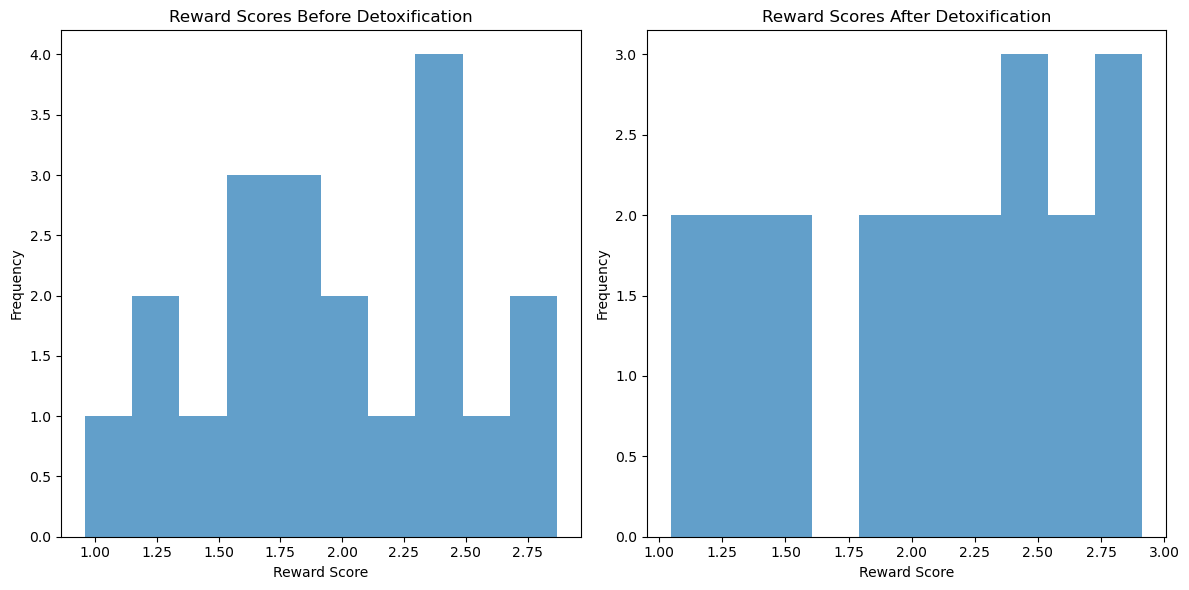

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(reward_scores_before, bins=10, alpha=0.7, label='Before Detoxification')
plt.xlabel('Reward Score')
plt.ylabel('Frequency')
plt.title('Reward Scores Before Detoxification')

plt.subplot(1, 2, 2)
plt.hist(reward_scores_after, bins=10, alpha=0.7, label='After Detoxification')
plt.xlabel('Reward Score')
plt.ylabel('Frequency')
plt.title('Reward Scores After Detoxification')

plt.tight_layout()
plt.show()

It appears that overall, there is a tendency for reward scores to improve across the dataset, despite instances where toxicity may increase after detoxification. It would be nice to investigate how this strategy impacts other datasets that may be more heavily corrupted than this dialogue-sum.

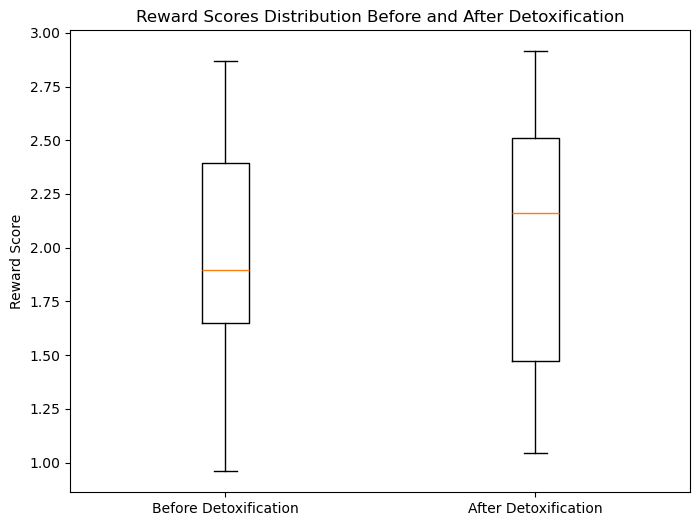

In [45]:
plt.figure(figsize=(8, 6))

plt.boxplot([reward_scores_before, reward_scores_after], labels=['Before Detoxification', 'After Detoxification'])
plt.ylabel('Reward Score')
plt.title('Reward Scores Distribution Before and After Detoxification')

plt.show()

Observation: the second box has a higher median -> tends to have higher reward values. As we have also seen previously from the statistics, the second one has also a higher spread 